In [54]:
import re
import os
import sys
sys.path.insert(0, '../src/')

import numpy as np
rng = np.random.RandomState(0)

import matplotlib.pyplot as plt
import scipy.stats as stats
import astropy.units as u
import pandas as pd

from galpy.df import jeans
from galpy import potential

import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

from modeling import vel_disp_profile
from utils import colobar_non_mappable

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
bins = np.linspace(0.12,0.3,10)

r_scale = 18.3 * u.arcmin.to(u.rad) * dist
dist = 4.5e3 * u.pc
R_bins = (bins* u.deg).to_value(u.rad) * dist

In [17]:
r_scale

<Quantity 23.95464398 pc>

In [28]:
x_bins = (bins[:-1]+bins[1:])/2
x_bins

array([0.13, 0.15, 0.17, 0.19, 0.21, 0.23, 0.25, 0.27, 0.29])

### Displaying Models

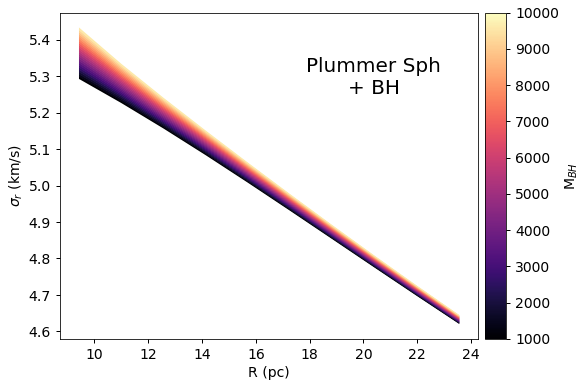

In [27]:
R = R_bins.copy()

N_mod = 25
models = np.zeros((N_mod, len(R))) * (u.km/u.s)
BH_amp = np.linspace(1e3,1e4,N_mod) * u.solMass

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_prop_cycle('color', plt.cm.magma(np.linspace(0,1,N_mod-1)))
for i, bh_amp in enumerate(BH_amp[:-1]):
    mod = vel_disp_profile(R, 1e6 * u.solMass-bh_amp, r_scale, bh_amp)
    models[i] = mod
    if i>0:
        plt.fill_between(R, models[i-1]-0.001*u.km/u.s, mod+0.001*u.km/u.s, edgecolor="None")
        
plt.xlabel("R (pc)")
plt.ylabel("$\sigma_r$ (km/s)")
plt.text(0.75,0.8,"Plummer Sph\n+ BH", fontsize=20,
         ha="center", va="center", transform=ax.transAxes)
        
colobar_non_mappable(fig, ax, vmin=BH_amp.value.min(),vmax=BH_amp.value.max())

### Realistic Synthetic Model

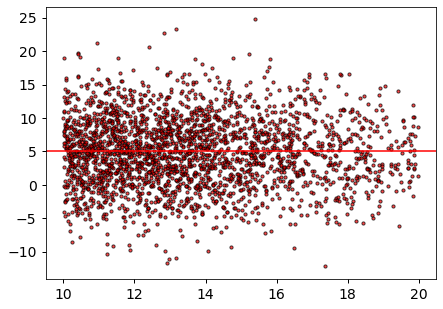

In [215]:
x = stats.truncnorm(loc=10, scale=5, a=0, b=2).rvs(2500) * u.pc
sigma = vel_disp_profile(x, 1e6 * u.solMass, r_scale, 2e4 * u.solMass).value
y = 5 + rng.normal(0, sigma, len(x))

plt.figure(figsize=(7,5))
plt.scatter(x, y, c='r', s=10, edgecolors=(0, 0, 0), alpha=0.7)
plt.axhline(5, c='r')

### Sampling using Dynesty

In [59]:
def prior(u):
    v = u.copy()
    v[0] = u[0] * 2 + 5          # amp
    v[1] = u[1] * 6 + 20         # scale
    v[2] = u[2] * 3.5 + 1        # BH amp
    return v

def loglike(v, R=x):
    log_amp, scale, log_BH_amp = v
    amp, BH_amp = 10**log_amp * u.solMass, 10**log_BH_amp * u.solMass
    
    pot = potential.PlummerPotential(amp=amp, b=scale*u.pc) + potential.KeplerPotential(amp=BH_amp)

    sigma = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in R])
    
    ypred = 5
        
    residsq = (ypred - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [60]:
nlive_init=100
nlive_batch=25
maxbatch=2
pfrac=0.8

dlogz = 1e-3 * (nlive_init - 1) + 0.01

In [61]:
pdsampler = dynesty.DynamicNestedSampler(loglike, prior, 3)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})

0it [00:00, ?it/s]

Exception while calling loglikelihood function:
  params: [ 6.08273077 20.24606133  3.03768073]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/mac/miniconda3/lib/python3.7/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-59-4e5429f2a29f>", line 14, in loglike
    sigma = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in R])
  File "<ipython-input-59-4e5429f2a29f>", line 14, in <listcomp>
    sigma = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in R])
  File "/Users/mac/miniconda3/lib/python3.7/site-packages/galpy/util/bovy_conversion.py", line 761, in wrapper
    return method(*args,**kwargs)
  File "/Users/mac/miniconda3/lib/python3.7/site-packages/galpy/util/bovy_conversion.py", line 682, in wrapped
    out= method(*args,**kwargs)
  File "/Users/mac/miniconda3/lib/python3.7/site-packages/galpy/df/jeans.py", line 56, in sigmar
    dens(r)/intFactor(r))
  File "/Users/mac/miniconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py", line 341, in quad
    points)
  File 

KeyboardInterrupt: 

### Try Grid Interpolation

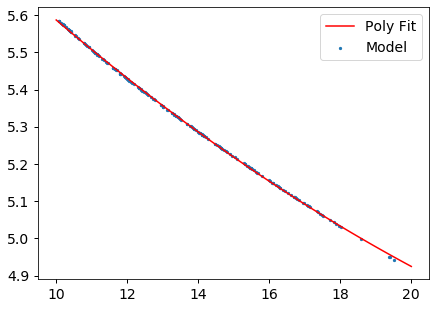

In [113]:
coef = np.polyfit(x, sigma, 2)
poly = np.poly1d(coef)
plt.scatter(x, sigma, s=5, label="Model")

xp = np.linspace(10, 20, 100)
plt.plot(xp, poly(xp), 'r-', label="Poly Fit")
plt.legend()

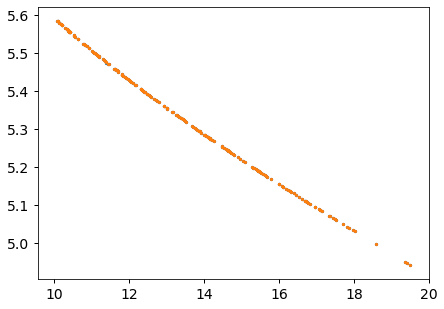

In [119]:
rp = xp * u.pc
pot = potential.PlummerPotential(amp=1e6*u.solMass, b=r_scale) + potential.KeplerPotential(amp=2e4*u.solMass)
yp = np.array([jeans.sigmar(pot, r).to_value(u.km/u.s) for r in rp])
sigma_p = np.interp(x, xp, yp)

plt.scatter(x, sigma, s=5, label="Model")
plt.scatter(x, sigma_p, s=5, label="Intp")

### Sampling Start From Here

In [247]:
N_amp = 3
N_BH = 20

Amp = np.linspace(9e5, 1.1e6, N_amp) * u.solMass
BH_amp = np.linspace(1e3, 4e4, N_BH) * u.solMass
print(Amp)
print(BH_amp)

models = np.zeros((N_amp, N_BH, len(xp))) * (u.km/u.s)

for i, amp in enumerate(Amp):
    for j, bh_amp in enumerate(BH_amp):
        model = vel_disp_profile(xp*u.pc, amp - bh_amp, r_scale, bh_amp)
        models[i,j] = model
        
i_true = np.argmin(abs(Amp-1e6*u.solMass))
j_true = np.argmin(abs(BH_amp-2e4*u.solMass))
print(i_true, j_true)

[ 900000. 1000000. 1100000.] solMass
[ 1000.          3052.63157895  5105.26315789  7157.89473684
  9210.52631579 11263.15789474 13315.78947368 15368.42105263
 17421.05263158 19473.68421053 21526.31578947 23578.94736842
 25631.57894737 27684.21052632 29736.84210526 31789.47368421
 33842.10526316 35894.73684211 37947.36842105 40000.        ] solMass
1 9


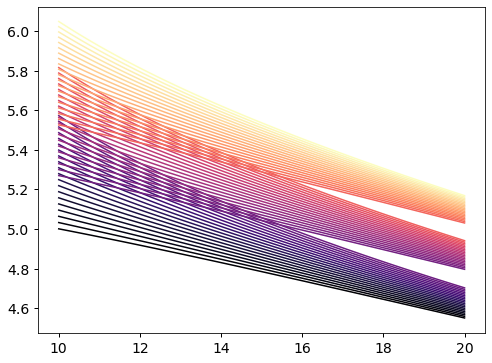

In [248]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_prop_cycle('color', plt.cm.magma(np.linspace(0,1,int(N_amp*N_BH))))
for i, amp in enumerate(Amp):
    for j, bh_amp in enumerate(BH_amp):
        model = models[i,j]
        plt.plot(xp, model)

In [249]:
def prior_grid(u):
    v = u.copy()
    v[0] = int(u[0]*N_amp)
    v[1] = int(u[1]*N_BH)
    return v

def loglike_grid(v):
    i, j = v
    model = models[int(i), int(j)]
    
    sigma = np.interp(x, xp, model)
    
    ypred = 5
        
    residsq = (ypred - y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))

    if not np.isfinite(loglike):
        loglike = -1e100

    return loglike

In [250]:
pdsampler = dynesty.DynamicNestedSampler(loglike_grid, prior_grid, 2)
pdsampler.run_nested(nlive_init=nlive_init, 
                     nlive_batch=nlive_batch, 
                     maxbatch=maxbatch, 
                     dlogz_init=dlogz, 
                     wt_kwargs={'pfrac': pfrac})

623it [00:03, 189.91it/s, batch: 2 | bound: 0 | nc: 2 | ncall: 4368 | eff(%): 14.263 | loglstar: -7682.811 < -7680.756 < -7681.028 | logz: -7682.577 +/-  0.140 | stop:  5.471]     


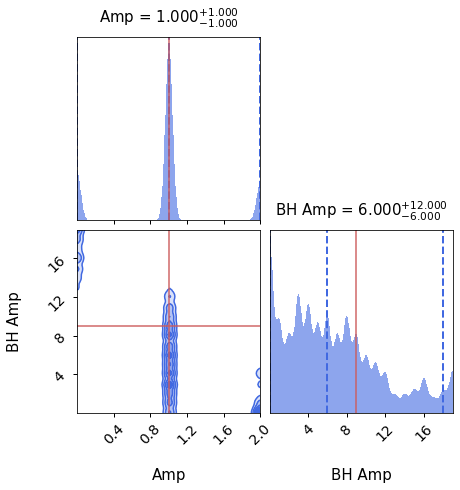

In [251]:
fig, ax = plt.subplots(2,2,figsize=(7,7))
dyplot.cornerplot(pdsampler.results, truths=[i_true,j_true], labels=["Amp", "BH Amp"], 
                  color="royalblue", truth_color="indianred",
                  title_kwargs={'fontsize':15, 'y': 1.04}, title_fmt='.3f',
                  label_kwargs={'fontsize':15}, show_titles=True, fig=(fig,ax))
plt.show()